In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import log_loss
import ast

# gets rid of scientific notation of arrays when printing
np.set_printoptions(suppress=True)

# shows all columns 
pd.set_option('display.max_columns', None) 

In [14]:
learning_rate = .000005

In [3]:
# softmax activation function
def softmax(x):
    expx = np.exp(x - np.max(x))
    return expx/np.sum(expx, axis=1, keepdims=True)

# relu activation function
def relu(x):
    return np.maximum(0, x)

# derivative of relu activation function
def drelu(x):
    return np.where(x > 0, 1, 0)

In [4]:
donordata = pd.read_csv('./data/clean-data.csv', index_col=None)

traindata = donordata.sample(frac=.7, random_state=1)
testdata = donordata.drop(traindata.index)

train_target_output = traindata.target_output.values
test_target_output = testdata.target_output.values

traindata = traindata.drop(['target_output'], axis=1)
traindata = traindata.set_index(['Contact_ID'], drop=True)
testdata = testdata.drop(['target_output'], axis=1)
testdata = testdata.set_index(['Contact_ID'], drop=True)

In [5]:
# one hot encode the target output for the train data
first = True
for x in train_target_output:
    if first:
        train_one_hot_encoded = np.array([ast.literal_eval(x)])
        first = False
    else:
        train_one_hot_encoded = np.append(train_one_hot_encoded, [ast.literal_eval(x)],axis=0)

In [6]:
# one hot encode the target output for the test data
first = True
for x in test_target_output:
    if first:
        test_one_hot_encoded = np.array([ast.literal_eval(x)])
        first = False
    else:
        test_one_hot_encoded = np.append(test_one_hot_encoded, [ast.literal_eval(x)],axis=0)

In [15]:
# initialize weights
np.random.seed(1)
weights_1 = np.random.randn(61,30)*np.sqrt(2/61)
weights_2 = np.random.randn(30,14)*np.sqrt(2/30)

# initialize bias
bias_1 = 1
bias_2 = 1

In [8]:
## takes in the inputs and adjusts the weights accordingly
# If train is false, it makes a prediction and doesn't adjust the weights
def train(batch, target_outputs, train):
    global weights_2
    global weights_1
    global bias_1
    global bias_2

    ## feedforward
    layer_1_output = relu(np.dot(batch, weights_1) + bias_1)
    output = softmax(np.dot(layer_1_output, weights_2) + bias_2)

    if train:
        ## backprop
        # output layer
        dcost_dpred = target_outputs - output
        dz_dw2 = layer_1_output

        dcost_dw2 = np.dot(dz_dw2.T, dcost_dpred)
        dcost_b2 = dcost_dpred

        dcost_doutput1 = np.dot(dcost_dpred, weights_2.T)
        doutput1_dz = drelu(layer_1_output)
        dz_dw1 = batch

        dcost_dw1 = np.dot(dz_dw1.T, dcost_doutput1 * doutput1_dz)
        dcost_b1 = dcost_doutput1 * doutput1_dz
        # update weights
        weights_2 += dcost_dw2 * learning_rate
        weights_1 += dcost_dw1 * learning_rate

        # update biases
        bias_2 += np.average(dcost_b2) * learning_rate
        bias_1 += np.average(dcost_b1) * learning_rate
    return output

In [16]:
error_list = []
index = []
train_data = preprocessing.scale(traindata.values)
for i in range(1001):
    train_output = train(train_data, train_one_hot_encoded, True)
    error = log_loss(train_one_hot_encoded, train_output)
    error_list.append(error)
    index.append(i)
    if (i % 100) == 0:
        print(error)

2.840915415141836
0.35445240364846736
0.32038522402375486
0.30459665935895003
0.2948634439776719
0.28835219072921625
0.28363523875612184
0.2799868917662131
0.2770124072750072
0.274430099523678
0.272210709243149


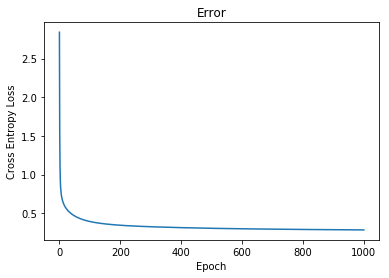

In [10]:
# plot error vs. epoch
plt.plot(index, error_list)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Error')
plt.show()

In [11]:
def classification_accuracy(targets, predictions) :
    total = len(predictions)
    correct = 0
    for i in range(total):
        predicted_class = np.argmax(predictions[i])
        if targets[i][predicted_class] == 1:
           correct += 1
    return correct/total

In [12]:
# classification accuracy of training data
classification_accuracy(train_one_hot_encoded, train_output)

0.9193430061949788

In [13]:
# classification accuracy of test data
test_data = preprocessing.scale(testdata.values)
test_output = train(test_data, test_one_hot_encoded, False)
classification_accuracy(test_one_hot_encoded, test_output)

0.9094712818562191